# Regresja logistyczna, walidacja, krzywe ROC

## Część I: regresja logistyczna
Ten notebook pomoże Ci zapoznać się z regresją logistyczną. 

Zbudujemy klasyfikator bazujący na regresji logistycznej. Jego zadaniem będzie określanie prawdopodobieństwa przyjęcia kandydata na studia na podstawie wyników z dwóch egzaminów maturalnych (każdy przeskalowany na zakres 0-100%): z matematyki i z biologii. 

Trzeba będzie uzupełnić kody funkcji:
*     sigmoida
*     funkcjaKosztu
*     predykcja
*     funkcjaKosztuReg

Zanim przejdziemy do właściwych zadań zaimportujmy potrzebne moduły:

In [1]:
import matplotlib
import numpy as np
import pylab as plt
import scipy.optimize as so
from ipywidgets import FloatProgress
from IPython.display import display

Dane do ćwiczenia zostały już opracowane przez wykładowcę i znajdują się w pliku:

https://brain.fuw.edu.pl/edu/images/d/d8/Reg_log_data1.txt.

Proszę je pobrać i zapisać na dysku Google'a (lub w bieżącym katalogu, jeśli pracujecie lokalnie). Jeśli pracujecie w Google Colab, to aby mieć dostęp do plików na dysku Google'a, należy go najpierw podłączyć do projektu następującą komendą:

In [3]:
folder = '/home/feigenbaum/Downloads/' # podaj lokalizację pliku

In [4]:
# W ten sposób można zapisywać dane do pliku na Google dysku
x = np.array([1,2,3,4])
np.savetxt(folder + 'test.txt', x, delimiter=',')

##  Wczytanie danych

Zawsze dobrze jest rozpocząć pracę od zapoznania się z danymi. W tym celu powinniśmy poznać strukturę danych: 
* Pierwsze dwie kolumny zawierają wyniki egzaminów (pierwsza z matematyki, druga z biologii),
* Trzecia kolumna zawiera etykietę (przynależność do grupy), po ang. *labels*

Wczytajmy dane i zobaczmy pierwsze 10 linii.

In [5]:
data = np.loadtxt(folder + 'Reg_log_data1.txt',delimiter=',')
print(data[:10,:])

[[34.62365962 78.02469282  0.        ]
 [30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]
 [45.08327748 56.31637178  0.        ]
 [61.10666454 96.51142588  1.        ]
 [75.02474557 46.55401354  1.        ]
 [76.0987867  87.42056972  1.        ]
 [84.43281996 43.53339331  1.        ]]


Aby łatwiej było się nimi posługiwać wydzielmy z nich dane wejściowe jako 'X' i wyjściowe jako 'Y':

In [6]:
X = data[:,:2] 
y = data[:,2]

O ile poziom skomplikowania problemu na to pozwala, zawsze dobrze jest zyskać dodatkową intuicję co do danych przez zobrazowanie ich. Zróbmy wykres punktowy (plt.scatter), w którym:
* żółty symbol oznacza przykłady gdzie y = 1 (przyjęty na studia) zaś 
* niebieski te z y = 0 (nieprzyjęty na studia)

Text(0, 0.5, 'wynik z biologii')

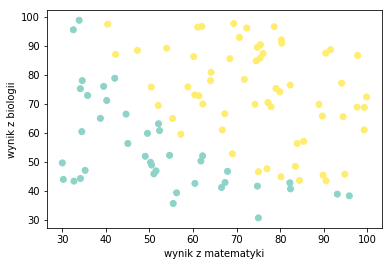

In [7]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Set3)
plt.xlabel('wynik z matematyki')
plt.ylabel('wynik z biologii')

Jak na poprzednich ćwiczeniach, wykorzystywany model ma wyraz wolny. Robimy to samo, co ostatnio, czyli aby wygodnie można było stosować oblicznia wektorowe do regresji logistycznej, to zmodyfikujemy macierz wejść X poprzez dodanie do niej z lewej strony kolumny jedynek. Będą one mnożyły  parametr $\theta_0$:

In [8]:
N = len(y) # liczba przykładów w zbiorze uczącym
XX = np.concatenate((np.ones((N,1)), X),axis = 1)

Zobaczmy jak teraz wygląda macierz XX:    

In [9]:
print(XX[:10,:])

[[ 1.         34.62365962 78.02469282]
 [ 1.         30.28671077 43.89499752]
 [ 1.         35.84740877 72.90219803]
 [ 1.         60.18259939 86.3085521 ]
 [ 1.         79.03273605 75.34437644]
 [ 1.         45.08327748 56.31637178]
 [ 1.         61.10666454 96.51142588]
 [ 1.         75.02474557 46.55401354]
 [ 1.         76.0987867  87.42056972]
 [ 1.         84.43281996 43.53339331]]


## Hipoteza
Dla przypomnienia _hipoteza_ w regresji logistycznej ma postać: 

$\qquad$ $h_\theta(x) = \frac{1}{1+\exp(-\theta^Tx)}$.

W implementacji dobrze jest myśleć o tej funkcji tak:

$\qquad$ $h_\theta(x) = \frac{1}{1+f}$.

gdzie: $f = \exp(-\theta^Tx)$

* zaimplementuj  hipotezę dla regresji logistycznej, 
* ze względu na stabilność numeryczną obliczeń dobrze jest ograniczyć zakres zmienności $f$ np do zakresu [1e-8, 1e+8]:

In [10]:
def hipoteza(x, theta):
    '''ta funkcja zwraca wartość hipotezy dla danego wejścia x i parametrów theta'''
    p=np.dot(x,theta)
    f = np.exp(-p)
    if f < 1e-8:
        f = 1e-8
    if f > 1e8:
        f = 1e8 
    h = 1/(1+f)
    return h

Przetestuj funkcję:

In [11]:
H0 = hipoteza(XX[0,:], np.zeros((3, 1)))
print('wartość hipotezy dla zerowego przykładu i dla początkowej thety: '+ str(H0))

wartość hipotezy dla zerowego przykładu i dla początkowej thety: [0.5]


Powino wyjść:

```wartość hipotezy dla zerowego przykładu i dla początkowej thety: [ 0.5]```

## Funkcja log-wiarygodności: 
* parametry regresji znajdujemy przez maksymalizację [funkcji log-wiarygodności](https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/Wykład_6#Funkcja_wiarygodno.C5.9Bci):

$\qquad$ $l(\theta) = \log L(\theta) = \sum_{j=1}^m y^{(j)} \log h(x^{(j)}) + (1 - y^{(j)}) \log (1 - h(x^{(j)}))$

In [12]:
def funkcjaLogWiarygodnosci(theta, X, y):
    '''Ta funkcja oblicza wartość funkcji log-wiarygodności  dla regresji logistycznej
    używając theta jako parametrów oraz X i y jako zbioru uczącego'''
    l=0.0
    # pętla po przykładach ze zbioru uczącego
    for j in range(len(y)): 
        h = hipoteza(X[j,:],theta)
        l +=  y[j]*np.log(h)+(1-y[j])*np.log(1-h)   
    return l   

W tym ćwiczeniu zrobimy to za pomocą funkcji optymalizacyjnych z modułu [<tt>scipy.optimize</tt>]( http://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize). 

Wynikają z tego dwie konsekwencje:
* Funkcje te są przystosowane do szukania minimów funkcji celu. Musimy więc podawać im jako argumenty funkcję minus log-wiarygodności

In [13]:
def minusFunkcjaLogWiarygodnosci(theta, X, y):
    return (-1.)*funkcjaLogWiarygodnosci(theta, X, y)

* Niektóre algorytmy mogą działać szybciej jeśli zaimplementujemy jawnie postać pochodnej:

$\qquad$ $
\begin{array}{lcl}
\frac{\partial}{\partial \theta_i} l(\theta)  =\sum_{j=1}^m (y^{(j)}-h_\theta(x^{(j)}))x_i^{(j)}
\end{array}
$

In [14]:
def pochodnaLogWiarygodnosci(theta, X, y):
    '''ta funkcja oblicza wartość pochodnej funkcji log-wiarygodności
    dla podaanych wartości theta, X i y'''
    dl_dtheta = np.zeros(len(theta))
    for i in range(len(theta)): # dla i-tej współrzędnej theta
        for j in range(len(y)):  # dodajemy przyczynki od przykładu j-ego 
            h = hipoteza(XX[j,:],theta)
            dl_dtheta[i] += (y[j]-h)*(X[j,i])
    return dl_dtheta

In [15]:
def minusPochodnaLogWiarygodnosci(theta, X, y):
    return (-1)*pochodnaLogWiarygodnosci(theta, X, y)

Inicjujemy parametry $\theta$ na wartości 0:

In [16]:
xDim = XX.shape[1] # rozmiar wejścia rozszerzonego o jedynki
theta0 = np.zeros((xDim, 1));

Zobaczmy jak wygląda początkowa $\theta$:

In [17]:
print(theta0)

[[0.]
 [0.]
 [0.]]


Obliczamy funkcje log-wiarygodności i jej pochodną dla danych początkowych:

In [18]:
logWiar = funkcjaLogWiarygodnosci(theta0, XX, y)
pochLogWiar = pochodnaLogWiarygodnosci(theta0, XX, y)

print( 'wartość log-wiarygodności dla początkowej thety: '+ str(logWiar))
print( 'pochodna log-wiarygodnosci dla poczatkowej thety: '+ str(pochLogWiar))

wartość log-wiarygodności dla początkowej thety: [-69.31471806]
pochodna log-wiarygodnosci dla poczatkowej thety: [  10.         1200.92165893 1126.28422055]


Przy prawidłowej implementacji pownino wyjść:
```
wartość log-wiarygodności dla początkowej thety: [-69.31471806]
pochodna log-wiarygodnosci dla poczatkowej thety: [   10.          1200.92165893  1126.28422055]
```

## Optymalizacja  

* Funkcje optymalizujące zaczerpniemy z modułu scipy.optimize
* Ponieważ funkcje te są zaimplementowane do mnimalizowania to zamiast maksymalizować funkcję low-wiarygodności będziemy minimalizować tą funkcje przemnożoną przez -1 czyli minusFunkcjaLogWiarygodnosci fprime=minusPochodnaLogWiarygodnosci,

In [19]:
theta_opt = so.fmin_bfgs(minusFunkcjaLogWiarygodnosci, theta0, 
                         fprime=minusPochodnaLogWiarygodnosci, 
                         args=(XX,y), disp= True)

Optimization terminated successfully.
         Current function value: 20.349770
         Iterations: 21
         Function evaluations: 28
         Gradient evaluations: 28


Wypiszmy dopasowane $\theta$:

In [20]:
print( 'Wartość log wiarygodnosci  dla optymalnych parametrów: '+
      str(funkcjaLogWiarygodnosci(theta_opt, XX, y)))
print( 'theta: '+str(theta_opt))

Wartość log wiarygodnosci  dla optymalnych parametrów: -20.349770158943993
theta: [-25.16133357   0.20623171   0.2014716 ]


## Wyniki
Wyniki regresji logistycznej możemy odbierać na dwa sposoby:
* obliczyć wartość hipotezy dla badanego wejścia i dopasowanych parametrów: miara ta ma interpretację prawdopodobieństwa przynależności wejścia do klasy 1,
* dopisać funkcję wykonującą klasyfikację, tzn. porównanie wartości hipotezy z 1/2: 
  * dla wartości hipotezy > 1/2 klasyfikacja zwraca 1, 
  * w przeciwnym razie 0.

In [21]:
def klasyfikacja(testX, theta):
    ''' Ta funkcja zwraca wynik klasyfikacji przykładu testX przy parametrach theta.
    Po obliczeniu hipotezy, jeśli otrzymane prawdopodobieństwo jest większe niż 0.5 to 
    zwraca 1 w przeciwnym wypadku zwraca 0'''
    h = h = hipoteza(testX,theta)
    if h > 0.5 :
        klasa = 1
    else:
        klasa = 0
        
    return klasa

## Przewidywanie 
Po dopasowaniu parametrów nadszedł czas aby zrobić predykcję.
Obliczmy jakie prawdopodobieństwo przyjęcia ma kandydat z wynikami
* 20 z matematyki
*  80 z biologii
Do przewidywania wykorzystujemy funkcję hipoteza, bo zgodnie z naszą interpretacją daje ona prawdopodobieństwo przyjęcia

In [22]:
prob = hipoteza([1, 20, 80], theta_opt)
print('dla kandydata z wymnikami 20 z matematyki i 80 z biologii prawdopodobieństwo przyjęcia wynosi: ' +str(prob))

dla kandydata z wymnikami 20 z matematyki i 80 z biologii prawdopodobieństwo przyjęcia wynosi: 0.007253643755667057


Używając funkcji <tt>klasyfikacja</tt> dostaniemy klasę:
    

In [23]:
klasa = klasyfikacja([1, 20, 80], theta_opt)
print('kandydat zalicza się do klasy: ' +str(klasa))

kandydat zalicza się do klasy: 0


Narysujmy uzyskany podział. Na tle punktów pokolorowanych zgodnie z przynalenością do klas dorysujemy prostą rozgraniczającą obszary "1" od "0".   Ma ona równanie 

$\qquad$ $h_\theta(x)=1/2$, 

tzn:

$\qquad$ $\theta^T x = 0$

czyli 

$\theta_0 +\theta_1 x_1 + \theta_2 x_2 =0 $

Przekształcając to do równania prostej we współrzędnych $(x_1,x_2)$ mamy:

$- \theta_2 x_2 = \theta_0 +\theta_1 x_1 $

$ x_2 = - \frac{1}{\theta_2}( \theta_0 +\theta_1 x_1 )$

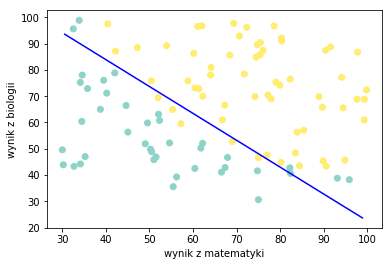

In [24]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set3)
plt.xlabel('wynik z matematyki')
plt.ylabel('wynik z biologii')

x_plot = np.array([np.min(X[:,1]), np.max(X[:,1])])
y_plot = -1./theta_opt[2]*(theta_opt[1]*x_plot + theta_opt[0])

plt.plot(x_plot,y_plot,'b')

## Walidacja
Teoria do tej części znajduje się tu:

https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/Wykład_Ocena_jakości_klasyfikacji

### Zastosowanie w naszym przykładzie
Dodamy teraz kross-walidację typu leave-one-out.
Po kolei odłożymy po jednym przykładzie ze zbioru uczącego i na takim zredukownaym zbiorze nauczymy regresję, a następnie sprawdzimy która z poniższych możliwych sytuacji zachodzi:
* TP:  stan faktyczny jest pozytywny (y=1) i klasyfikator się nie myli (wynik = 1)
* TN:  stan faktyczny jest negatywny (y=0) i klasyfikator się nie myli (wynik = 0) 
* FP:   wynik fałszywie pozytywny (fałszywy alarm): stan faktyczny jest negatywny (y=0) ale klasyfikator się  myli (wynik = 1)
* FN: przegapiony alarm: stan faktyczny jest pozytywny (y=1) i klasyfikator się myli (wynik = 0)


Przygotowujemy liczniki:

In [25]:
TP = 0 
TN = 0
FP = 0 
FN = 0

 W pętli odkładamy przykład `v` do testowania:

In [26]:
for v in range(len(y)):
    testX = XX[v]
    testY = y[v]
    # robimy zredukowany zbiór uczący przez usunięcie przykładu v
    uczX = np.delete(XX,v,axis=0)
    uczY = np.delete(y,v)
    # uczymy regresję na zredukowanym zbiorze uczącym
    theta_opt_t = so.fmin_bfgs(minusFunkcjaLogWiarygodnosci, theta0,
                             fprime=minusPochodnaLogWiarygodnosci, 
                             args=(uczX, uczY), disp= False)
   # klasyfikujemy odłożony przykład : proszę uzupełnić funkcję klasyfikacja na początku pliku
    wynik = klasyfikacja(testX , theta_opt_t)
    # aktualizujemy liczniki; proszę uzupełnić kod:
    if testY == 1 and wynik == 1:
            TP += 1
    if testY == 1 and wynik == 0:
            FN +=1           
    if testY == 0 and wynik == 1:
            FP +=1
    if testY == 0 and wynik == 0:
            TN +=1
print('TP: ', TP)
print('FP: ', FP)
print('TN: ', TN)
print('FN: ', FN)

TP:  56
FP:  9
TN:  31
FN:  4


Dla naszego zbioru uczącego powinniśmy uzyskać:
```
TP:  55
FP:  6
TN:  34
FN:  5
```

## Krzywa ROC

Aby wykreślić krzywą ROC należy przeprowadzić klasyfikację dla wielu możliwych wartości progu dla hipotezy, powyżej którego uznajemy przypadek za należący do klasy 1.


Modyfikujemy funkcję klasyfikacja, tak aby wynik zależał też od progu:

In [27]:
def klasyfikacjaProg(testX, theta,prog):
    h = hipoteza(testX, theta)
    if h > prog:
        klasa = 1
    else:
        klasa = 0
    return klasa

Funkcję tą możemy wykorzystać do obliczenia liczebności poszczególnych przypadków klasyfikacji w zależności od progu:

In [28]:
def liczROC(XX,y,progi):
    '''funkcja oblicza FPR i TPR dla zadanych progów,
       progi dla których mają być wyliczone wyniki podajemy w postaci wektora
       '''
    TP = np.zeros(len(progi))
    TN = np.zeros(len(progi))
    FP = np.zeros(len(progi))
    FN = np.zeros(len(progi))
    f = FloatProgress(min=0, max=len(y))
    display(f)
    for v in range(len(y)):
        f.value+=1
        
        testX = XX[v]
        testY = y[v]
        tenX = np.delete(XX,v,axis=0)
        tenY = np.delete(y,v)
        theta_opt_t = so.fmin_bfgs(minusFunkcjaLogWiarygodnosci, theta0, 
                                 fprime=minusPochodnaLogWiarygodnosci, 
                                 args=(tenX,tenY), disp= False)
        for ind, prog in enumerate(progi):
            wynik = klasyfikacjaProg(testX, theta_opt_t,prog)
            if testY == 1 and wynik == 1:
                TP[ind] += 1
            if testY == 1 and wynik == 0:
                FN[ind] +=1           
            if testY == 0 and wynik == 1:
                FP[ind] +=1
            if testY == 0 and wynik == 0:
                TN[ind] +=1
            
            
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN) 
    return (FPR,TPR)


Do wykreślenia krzywej ROC możesz użyć następującego kodu. Zaznaczamy w nim na wykresie wartości progów dla których osiągnięto konkretne wartości FPR i TPR.

FloatProgress(value=0.0)

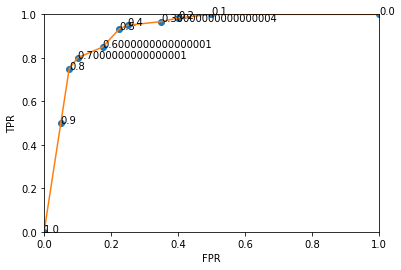

In [29]:
progi = np.arange(0.0,1.1,0.1)
FPR,TPR= liczROC(XX,y,progi)
plt.figure()
plt.plot(FPR,TPR,'o')
plt.plot(FPR,TPR)
for ind,pr in enumerate(progi):
    plt.text(FPR[ind],TPR[ind],str(pr))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim((0,1))
plt.ylim((0,1))
plt.show()

Policzmy jeszcze pole pod krzywą ROC, tzw. AUC (area under curve), za pomocą metody trapezów: 

In [30]:
AUC = 0
for ind in range(len(progi)-1):
    a = TPR[ind]
    b = TPR[ind+1]
    h = 0.1
    AUC += 0.5*(a+b)*h
print('AUC: ',AUC)

AUC:  0.8233333333333335


Spodziewamy się wyniku:
```
AUC:  0.9375
```